# 1 + 1 = 1 or Record Deduplication with Python
Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  

<p>
    Partner at <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width=300></a>
</p>

Check the other Vinta talks at: http://bit.ly/vinta-pygotham18

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging; logging.disable(level=logging.INFO)

<p style="font-size: 2em; text-weight: bold">
    Slides available at: <a href="http://bit.ly/pygotham-dup">bit.ly/pygotham-dup</a>
</p>
<p>
    Jupyter Notebook source at: <a href="https://github.com/vintasoftware/deduplication-slides/">github.com/vintasoftware/deduplication-slides/</a>
</p>

## Real world data is a mess!
Probably you dealt with data like this before:

In [2]:
import pandas as pd

data = [
    ("Art's Delicatessen","12224 Ventura Blvd","Studio City"),
    ("Arts Deli","12224 Ventura Blvd.","LA"),
    ("Art's Deli and Restaurant","12224 Ventura Boulevard","Los Angeles"),
    ("Art's Delicatessen & Restaurant","12220 Ventura Blvd.","LA"),
    ("Fringale", "570 4th St.", "San Francisco"),
    ("Fringale Restaurant", "570 Fourth Street", "SF"),
]

df = pd.DataFrame(data, columns=['restaurant', 'address', 'city'])

In [3]:
df

,restaurant,address,city
0,Art's Delicatessen,12224 Ventura Blvd,Studio City
1,Arts Deli,12224 Ventura Blvd.,LA
2,Art's Deli and Restaurant,12224 Ventura Boulevard,Los Angeles
3,Art's Delicatessen & Restaurant,12220 Ventura Blvd.,LA
4,Fringale,570 4th St.,San Francisco
5,Fringale Restaurant,570 Fourth Street,SF


The solution is to perform **Deduplication** (aka [Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)). It works by joining records in a **fuzzy way** using data like names, addresses, phone numbers, dates, etc.

## Fuzzy comparison of strings

In [4]:
import jellyfish

In [5]:
jellyfish.jaro_winkler("Art's Delicatessen", "Arts Deli")

0.8833333333333334

In [6]:
jellyfish.jaro_winkler("Arts Deli", "Fringale")

0.4583333333333333

## Fuzzy comparison of addresses

Geocoding street addresses, i.e., converting them to **latitude/longitude** is very useful for matching because geocoders can:
- clean irrelevant address variations
- enable the calculation of geometric distance using lat/lng

In [7]:
import requests
import geocoder

full_addresses = [
    "20863 Stevens Creek Blvd., ste 330, 95015, CUPERTINO, CA, USA",
    "20863 STEVENS CREEK Boulevard STE 330, 95014, Cupertio, CA, USA",
]

full_addresses_latlng = []
with requests.Session() as session:
    for a in full_addresses:
        a_geocoded = geocoder.google(a, session=session)
        full_addresses_latlng.append((a_geocoded.latlng, a_geocoded.postal))

address_latlng = list(zip(full_addresses, full_addresses_latlng))

In [8]:
import pprint

pprint.pprint(address_latlng)

[('20863 Stevens Creek Blvd., ste 330, 95015, CUPERTINO, CA, USA',
  ([37.3241563, -122.0387297], '95014')),
 ('20863 STEVENS CREEK Boulevard STE 330, 95014, Cupertio, CA, USA',
  ([37.3241563, -122.0387297], '95014'))]


Google geocoder is able to ignore the following variations:
- Lower/upper case
- Blvd. vs Boulevard
- Zipcode 95015 vs 95014
- Cupertino vs Cupertio

## 0/4 - Preprocessing

Custom dataset based on [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset:
- a well-known dataset used by researchers
- made of 881 restaurant records from the Fodor's and Zagat's restaurant guides
- contains 150 duplicates

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [9]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


The dataset comes with the true matches indicated by the `cluster` column.

We'll also remove the `phone` and `type` to makes things more difficult:

In [10]:
df = df_with_truth.drop(columns=['cluster', 'phone', 'type'])
df.head(9)

,name,addr,city
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art's delicatessen,12224 ventura blvd.,studio city
4,art's deli,12224 ventura blvd.,studio city
5,art's deli,12224 ventura blvd.,los angeles
6,hotel bel-air,701 stone canyon rd.,bel air
7,bel-air hotel,701 stone canyon rd.,bel air
8,bel-air,701 stone canyon road,bel air


Now we'll clean the column values! Cleaning `name`:

In [11]:
import re

irrelevant_regex = re.compile(r'[^a-z0-9\s]')
multispace_regex = re.compile(r'\s\s+')

def assign_no_symbols_name(df):
    return df.assign(
        name=df['name']
             .str.replace(irrelevant_regex, ' ')
             .str.replace(multispace_regex, ' '))

df = assign_no_symbols_name(df)
df.head(9)

,name,addr,city
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art s delicatessen,12224 ventura blvd.,studio city
4,art s deli,12224 ventura blvd.,studio city
5,art s deli,12224 ventura blvd.,los angeles
6,hotel bel air,701 stone canyon rd.,bel air
7,bel air hotel,701 stone canyon rd.,bel air
8,bel air,701 stone canyon road,bel air


Geocoding `addr`:

In [12]:
import numpy as np

all_addresses = df['addr'].str.cat(df['city'], sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [13]:
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None and 'lat' in v))

    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 7
Failed to get latlng from 0


In [14]:
def assign_postal_lat_lng(df):
    addresses = df['addr'].str.cat(df['city'], sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_lat = [address_to_latlng[a][0] if a in address_to_latlng else None for a in addresses]
    addresses_to_lng = [address_to_latlng[a][1] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, lat=addresses_to_lat, lng=addresses_to_lng)

df = assign_postal_lat_lng(df)
df.head(6)

,name,addr,city,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,90048,34.070609,-118.376722
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,34.070609,-118.376722
3,art s delicatessen,12224 ventura blvd.,studio city,91604,34.142966,-118.399469
4,art s deli,12224 ventura blvd.,studio city,91604,34.142966,-118.399469
5,art s deli,12224 ventura blvd.,los angeles,91604,34.142966,-118.399469


## 1/4 - Indexing

For the next steps, we'll use the library **recordlinkage**, aka **[Python Record Linkage Toolkit](http://recordlinkage.readthedocs.io/en/stable/)**.

We have the cleaned records, now we want the **pairs** to compare to find matches.

To **produce** the pairs, we could do a "full" index, i.e., all records against all records:

In [15]:
import recordlinkage as rl
from recordlinkage.index import Full

full_indexer = Full()
pairs = full_indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 881 records, 387640 pairs


The number of pairs grows too fast as the number of records grows:  
it **grows quadratically** with the formula `len(df) * (len(df) - 1) / 2`

To avoid wasting too much time, we need **indexing**. We need to produce only pairs that are good candidates of being duplicates.

A basic way to index is **blocking**: produce pairs that have **some value in common**.

Below we compute pairs that have **equal values for postal** code:

In [16]:
from recordlinkage.index import Block

postal_indexer = Block('postal')
pairs = postal_indexer.index(df)

print(f"Postal index: {len(pairs)} pairs")

Postal index: 6577 pairs


In [17]:
# We'll swap the levels of pairs MultiIndex returned by recordlinkage
# to make it simpler to interpret. Here we get the upper triangle of the pairs matrix.
pairs = pairs.swaplevel().sortlevel()[0]

In [18]:
pairs.to_frame()[:10].values

array([[  0,   1],
       [  0,   2],
       [  0,  35],
       [  0,  36],
       [  0, 262],
       [  0, 266],
       [  0, 273],
       [  0, 293],
       [  0, 685],
       [  0, 695]])

## 2/4 - Comparison

Now we want to run comparisons on the indexed pairs to produce **a comparison vector for each pair**. For example:

In [19]:
pd.DataFrame([[0.5, 0.8, 0.9, 1]],
             columns=['name', 'addr', 'postal', 'latlng'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,postal,latlng
100,200,0.5,0.8,0.9,1


The pair of records `(100, 200)` has:
- Low similarity on `name`s
- Some similarity on `addr`s
- High similarity on `postal`s
- Equal `latlng`s

To compute the comparison vectors, we define a **similarity function** for each column:

In [20]:
comp = rl.Compare()
comp.string('name', 'name', method='jarowinkler', label='name')
comp.string('addr', 'addr', method='jarowinkler', label='addr')
comp.string('postal', 'postal', method='jarowinkler', label='postal')
comp.geo('lat', 'lng', 'lat', 'lng', method='exp', scale=0.1, offset=0.01, label='latlng');

Now we'll compute the **comparison vectors**:

In [21]:
comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head(5)

name      addr  postal    latlng
0 1    1.000000  0.985507     1.0  1.000000
  2    0.896000  0.910774     1.0  1.000000
  35   0.505476  0.528075     1.0  0.031305
  36   0.505476  0.478788     1.0  0.031305
  262  0.413333  0.743613     1.0  0.016543

Now, with our comparison vectors, we'll explore **different ways** to classify them as matches and nonmatches.

## 3/4 - Classification

### Threshold-Based Classification

A simple way to classify comparison vectors as matches or nonmatches is to compute a **weighted average** over the vectors to get a **score**:

In [22]:
scores = np.average(
    comparison_vectors.values,
    axis=1,
    weights=[50, 30, 10, 20])
scored_comparison_vectors = comparison_vectors.assign(score=scores)
scored_comparison_vectors.head(5)

name      addr  postal    latlng     score
0 1    1.000000  0.985507     1.0  1.000000  0.996047
  2    0.896000  0.910774     1.0  1.000000  0.928393
  35   0.505476  0.528075     1.0  0.031305  0.470383
  36   0.505476  0.478788     1.0  0.031305  0.456941
  262  0.413333  0.743613     1.0  0.016543  0.484599

By looking at the data, we know record `0` truly matches `1` and `2`, so we'll **classify as a match** any pair with score `>= 0.9`. That's our **threshold**:

In [23]:
df.head(5)

,name,addr,city,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,90048,34.070609,-118.376722
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,34.070609,-118.376722
3,art s delicatessen,12224 ventura blvd.,studio city,91604,34.142966,-118.399469
4,art s deli,12224 ventura blvd.,studio city,91604,34.142966,-118.399469


In [24]:
matches = scored_comparison_vectors[
    scored_comparison_vectors['score'] >= 0.9]
matches.head(5)

name      addr  postal  latlng     score
0 1  1.000000  0.985507     1.0     1.0  0.996047
  2  0.896000  0.910774     1.0     1.0  0.928393
1 2  0.896000  0.923779     1.0     1.0  0.931940
3 4  0.911111  1.000000     1.0     1.0  0.959596
  5  0.911111  1.000000     1.0     1.0  0.959596

Since we have the true match status on `cluster` column, we can **evaluate** how well our threshold classification did:

In [25]:
golden_pairs = Block('cluster').index(df_with_truth)
golden_pairs = golden_pairs.swaplevel().sortlevel()[0]
print("Golden pairs:", len(golden_pairs))

Golden pairs: 150


In [26]:
found_pairs_set = set(matches.index)

golden_pairs_set = set(golden_pairs)

true_positives = golden_pairs_set & found_pairs_set
false_positives = found_pairs_set - golden_pairs_set
false_negatives = golden_pairs_set - found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))

true_positives total: 128
false_positives total: 2
false_negatives total: 22


We've got a small number of **false positives**. Some are really tricky cases:

In [27]:
print(f"False positives:")
for false_positive_pair in false_positives:
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'postal', 'lat', 'lng']])

False positives:


,name,addr,postal,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,30326,33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,30326,33.850807,-84.364227


,name,addr,postal,lat,lng
200,ritz carlton restaurant,181 peachtree st.,30303,33.758579,-84.387066
839,ritz carlton cafe atlanta,181 peachtree st.,30303,33.758579,-84.387066


On the other hand, we got a lot of **false negatives**. We've **missed** a lot of matches!

In [28]:
print(f"False negatives (sample 10 of {len(false_negatives)}):")
for false_negative_pair in list(false_negatives)[:10]:
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'postal', 'lat', 'lng']])

False negatives (sample 10 of 22):


,name,addr,postal,lat,lng
170,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,30326,33.846181,-84.364109
171,brasserie le coze,3393 peachtree rd.,30326,33.846869,-84.362512


,name,addr,postal,lat,lng
182,heera of india,595 piedmont ave. rio shopping mall,30324,33.795817,-84.370602
183,heera of india,595 piedmont ave.,30308,33.770495,-84.381425


,name,addr,postal,lat,lng
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,30305,33.820137,-84.387280
165,abruzzi,2355 peachtree rd. ne,30305,33.824647,-84.387453


,name,addr,postal,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,90027,34.107405,-118.28719
29,katsu,1972 hillhurst ave.,90027,34.107405,-118.28719


,name,addr,postal,lat,lng
36,locanda veneta,8638 w 3rd,90048,34.073417,-118.381096
37,locanda,w. third st.,None,34.068944,-118.322451


,name,addr,postal,lat,lng
40,the palm,9001 santa monica blvd.,90069,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,90069,34.083064,-118.387282


,name,addr,postal,lat,lng
136,shun lee west,43 w. 65th st.,10023,40.772900,-73.981348
137,shun lee palace,155 e. 55th st.,10022,40.759428,-73.969068


,name,addr,postal,lat,lng
34,locanda veneta,3rd st.,None,33.494790,-112.069374
35,locanda veneta,8638 w. third st.,90048,34.073417,-118.381096


,name,addr,postal,lat,lng
30,l orangerie,903 n. la cienega blvd.,90069,34.087098,-118.376626
31,l orangerie,903 n. la cienega blvd.,90028,34.100833,-118.325613


,name,addr,postal,lat,lng
35,locanda veneta,8638 w. third st.,90048,34.073417,-118.381096
37,locanda,w. third st.,None,34.068944,-118.322451


Bue we've set the weights and the threshold **by guessing**, could we do any better?

### Supervised Classification

Instead of trying to guess weights and thresholds, we can train a **classifier** to learn how to classify matches and nonmatches based on some training data we provide:

In [29]:
df_training = pd.read_csv('restaurant-training.csv', skip_blank_lines=True)
df_training = df_training.drop(columns=['type', 'phone'])
df_training

,name,addr,city,cluster
0,locanda veneta,3rd st.,los angeles,13
1,locanda veneta,8638 w. third st.,los angeles,13
2,locanda veneta,8638 w 3rd,st los angeles,13
3,cafe lalo,201 w. 83rd st.,new york,26
4,cafe lalo,201 w. 83rd st.,new york city,26
5,les celebrites,160 central park s,new york,42
6,les celebrites,155 w. 58th st.,new york city,42
7,second avenue deli,156 2nd ave. at 10th st.,new york,58
8,second avenue deli,156 second ave.,new york city,58
9,smith & wollensky,201 e. 49th st.,new york,62


We need to **preprocess** our training data too:

In [30]:
df_training = assign_no_symbols_name(df_training)
df_training = assign_postal_lat_lng(df_training)
df_training.head(5)

,name,addr,city,cluster,postal,lat,lng
0,locanda veneta,3rd st.,los angeles,13,None,33.494790,-112.069374
1,locanda veneta,8638 w. third st.,los angeles,13,90048,34.073417,-118.381096
2,locanda veneta,8638 w 3rd,st los angeles,13,90048,34.073417,-118.381096
3,cafe lalo,201 w. 83rd st.,new york,26,10024,40.785981,-73.976727
4,cafe lalo,201 w. 83rd st.,new york city,26,10024,40.785981,-73.976727


We'll feed a **Support Vector Machine classifier** with our training data. SVMs are good for deduplication because they:
- Are resilient to noise
- Can handle correlated features (like 'addr' and 'latlng')
- Are robust to imbalanced training sets (and that's natural on deduplication projects) [3]

In [31]:
all_training_pairs = Full().index(df_training)
matches_training_pairs = Block('cluster').index(df_training)

training_vectors = comp.compute(all_training_pairs, df_training)

svm = rl.SVMClassifier()
svm.fit(training_vectors, matches_training_pairs);

In [32]:
svm_pairs = svm.predict(comparison_vectors)
svm_found_pairs_set = set(svm_pairs)

svm_true_positives = golden_pairs_set & svm_found_pairs_set
svm_false_positives = svm_found_pairs_set - golden_pairs_set
svm_false_negatives = golden_pairs_set - svm_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))

true_positives total: 128
false_positives total: 2
false_negatives total: 22

svm_true_positives total: 133
svm_false_positives total: 2
svm_false_negatives total: 17


There are [other classifiers](https://recordlinkage.readthedocs.io/en/stable/notebooks/classifiers.html) from recordlinkage library we could try, but the truth is:
- It's **very difficult to build a good training set** that takes in account all important cases of matches/nonmatches;
- It's possible to tune classifier parameters, but it's very difficult to **decide parameters that will generalize well** for future predictions;
- And we're not even sure **if the indexing rules we used are really sane**. We could be:
  * missing matches due blocking
  * introducing mismatches due blocking + forgiving classifier

The **alternative** to all that uncertainty is...

### Active Learning Classification

Active Learning methods identify **training examples** that "lead to maximal accuracy improvements" [3], to train both:
- optimal **classifier weights**
- optimal **indexing/blocking rules**

A Python library called [**Dedupe**](https://docs.dedupe.io/en/latest/index.html) implements that. Let's see it in practice:

In [33]:
import logging; logging.disable(level=logging.NOTSET)

In [34]:
from svm_dedupe import SVMDedupe
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'JaroWinkler',
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'JaroWinkler',
    },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'JaroWinkler'
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'ExpLatLong'
    },
]

deduper = SVMDedupe(fields)

In [35]:
settings_filename = 'dedupe-simple-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)

INFO:dedupe.api:((SimplePredicate: (firstIntegerPredicate, addr), SimplePredicate: (sameFiveCharStartPredicate, name)), (SimplePredicate: (latLongGridPredicate, latlng), SimplePredicate: (oneGramFingerprint, name)))


We need to **adapt** the data a bit to the format Dedupe wants:

In [36]:
data_for_dedupe = df.assign(cluster=df_with_truth['cluster']).to_dict('index')
for record in data_for_dedupe.values():
    # Change nans to None
    for k, v in record.items():
        if isinstance(v, float) and np.isnan(v):
            record[k] = None
    
    # Move lat and lng to a single field latlng
    lat = record.pop('lat')
    lng = record.pop('lng')
    if lat is not None and lng is not None:
        record['latlng'] = (lat, lng)
    else:
        record['latlng'] = None

We train Dedupe by **labeling** the examples of matches and nonmatches it asks us:

In [37]:
#     deduper.sample(data_for_dedupe)  
#     dedupe.consoleLabel(deduper)
#     deduper.train(index_predicates=False)

with open('training-simple-input-output.txt') as t:
    print('\n'.join(t.read().split('\n')[:262]))
    print('...')

name : philippe the original
addr : 1001 north alameda
postal : 90012
latlng : (34.059721, -118.237025)

name : pisces
addr : 95 ave. a
postal : 10009
latlng : (40.7256332, -73.984031)

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : philippe the original
addr : 1001 n. alameda st.
postal : 90012
latlng : (34.059721, -118.237025)

name : mon kee seafood restaurant
addr : 679 n. spring st.
postal : 90012
latlng : (34.0595568, -118.2382488)

0/10 positive, 1/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : caffe vivaldi
addr : 32 jones st. at bleecker st.
postal : 10014
latlng : (40.7317316, -74.00298049999999)

name : patria
addr : 250 park ave. s at 20th st.
postal : 10003
latlng : (40.7382552, -73.988214)

0/10 positive, 2/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : i trulli
addr : 122 e. 27th st.  between le

You can check the full training at `training-simple-input-output.txt`.

If you want to train it yourself, do a `rm dedupe-simple-settings.pickle dedupe-simple-training.json` and run this whole Active Learning session again.

In [38]:
from dedupe.convenience import unique

def auto_label(deduper):
    # based on: dedupe.convenience.consoleLabel
    fields = unique(field.field
                    for field
                    in deduper.data_model.primary_fields)
    n_match = 0
    n_distinct = 0
    buffer_len = 1
    examples_buffer = []
    uncertain_pairs = []
    
    while n_match < 12 or n_distinct < 20:
        if not uncertain_pairs:
            uncertain_pairs = deduper.uncertainPairs()
        record_pair = uncertain_pairs.pop()
        
        n_match = (len(deduper.training_pairs['match']) +
                   sum(label == 'match' for _, label in examples_buffer))
        n_distinct = (len(deduper.training_pairs['distinct']) +
                      sum(label == 'distinct' for _, label in examples_buffer))
        
        for pair in record_pair:
            for field in fields:
                line = "%s : %s" % (field, pair[field])
                print(line)
            print()
        print(f"{n_match}/10 positive, {n_distinct}/10 negative")
        print("Do these records refer to the same thing?")
        print("(y)es / (n)o / (u)nsure / (f)inished")
        
        if record_pair[0]['cluster'] == record_pair[1]['cluster']:
            print('y')
            examples_buffer.insert(0, (record_pair, 'match'))
        else:
            print('n')
            examples_buffer.insert(0, (record_pair, 'distinct'))
        print()

        if len(examples_buffer) > buffer_len:
            record_pair, label = examples_buffer.pop()
            if label in ['distinct', 'match']:
                examples = {'distinct': [], 'match': []}
                examples[label].append(record_pair)
                deduper.markPairs(examples)
    
    for record_pair, label in examples_buffer:
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.markPairs(examples)

In [39]:
if not isinstance(deduper, dedupe.StaticDedupe):
    deduper.sample(data_for_dedupe)
    
    training_filename = 'dedupe-simple-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.readTraining(tf)

#     dedupe.consoleLabel(deduper)
    auto_label(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.writeTraining(tf)
    
    deduper.train(index_predicates=False)
    
    with open(settings_filename, 'wb') as sf:
        deduper.writeSettings(sf)

After training, we can see which **blocking predicates** (indexing rules) the deduper learned from our training input. It's good to do that to check if we trained enough:

In [40]:
deduper.predicates

((SimplePredicate: (firstIntegerPredicate, addr),
  SimplePredicate: (sameFiveCharStartPredicate, name)),
 (SimplePredicate: (latLongGridPredicate, latlng),
  SimplePredicate: (oneGramFingerprint, name)))

The deduper selected those predicates from this extense list of **possible predicates**:

In [41]:
deduper.data_model.predicates()

{LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredicate: (commonFourGram, addr),
 SimplePredicate: (commonFourGram, name),
 SimplePredicate: (commonFourGram, postal),
 SimplePredicate: (commonIntegerPredicate, addr),
 SimplePredicate: (commonIntegerPredicate, name),
 SimplePredicate: (commonIntegerPredicate, postal),
 SimplePredicate: (commonSixGram, addr),
 SimplePredicate: (commonSixGram, name),
 

To proceed with the deduplication, we compute the **clustering threshold** and call the actual **match**:

In [42]:
import itertools

threshold = deduper.threshold(data_for_dedupe, recall_weight=2)
clustered_dupes = deduper.match(data_for_dedupe, threshold)

dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:  # we'll explain that later
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.999
INFO:dedupe.api:precision: 0.705
INFO:dedupe.api:With threshold: 0.209


Now we'll **evaluate** how it performed:

In [43]:
dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))
print()
print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

true_positives total: 128
false_positives total: 2
false_negatives total: 22

svm_true_positives total: 133
svm_false_positives total: 2
svm_false_negatives total: 17

dedupe_true_positives total: 141
dedupe_false_positives total: 3
dedupe_false_negatives total: 9


## 4/4 - Clustering

Using the Threshold or the SVM, we got the **matching pairs**. But what Dedupe returned to us were **clusters of matches**:

In [44]:
clustered_dupes[:5]

[((0, 1, 2), array([0.71874997, 0.71926606, 0.68507835])),
 ((3, 4, 5), array([0.70119166, 0.72756007, 0.72756007])),
 ((6, 7, 8), array([0.23452896, 0.58216786, 0.34763891])),
 ((9, 10, 11, 12), array([0.75352858, 0.75352858, 0.75352858, 0.75272876])),
 ((13, 14), (0.7539285, 0.7539285))]

Dedupe went one step further on the process and **merged the matching pairs into clusters**! Why is that important? Because the following can happen:
- We have the records `A`, `B`, and `C`
- By deduplicating, we find:
- `(A, B)` match
- `(B, C)` match
- `(A, C)` nonmatch
- And that doesn't make sense!

The solution for that ambiguity is computing the **Transitive Closure** through clustering.

Using some private methods from Dedupe, it's possible to get the **unclustered pairs**:

In [45]:
from dedupe.core import scoreDuplicates

candidate_records = itertools.chain.from_iterable(deduper._blockedPairs(deduper._blockData(data_for_dedupe)))
dedupe_matches = scoreDuplicates(candidate_records,
                                 deduper.data_model,
                                 deduper.classifier,
                                 deduper.num_cores)
dedupe_unclustered_pairs_score_dict = {tuple(pair): score for (pair, score) in dedupe_matches}
dedupe_unclustered_found_pairs_set = set(dedupe_unclustered_pairs_score_dict.keys())

Let's **evaluate** those unclustered pairs against the clustered pairs:

In [46]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 141
dedupe_false_positives total: 3
dedupe_false_negatives total: 9

dedupe_unclustered_true_positives total: 139
dedupe_unclustered_false_positives total: 5
dedupe_unclustered_false_negatives total: 11


Unclustered pairs `!=` Clustered pairs.

Though necessary, the clustering process can both **create new matches** and **drop found matches**

In [47]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(6, 8), (40, 41), (120, 471), (121, 471), (196, 198), (199, 839)}

,name,addr,city,postal,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,90069,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,90069,34.083064,-118.387282
42,the palm los angeles,9001 sta monica boulevard,hollywood,90069,34.083064,-118.387282


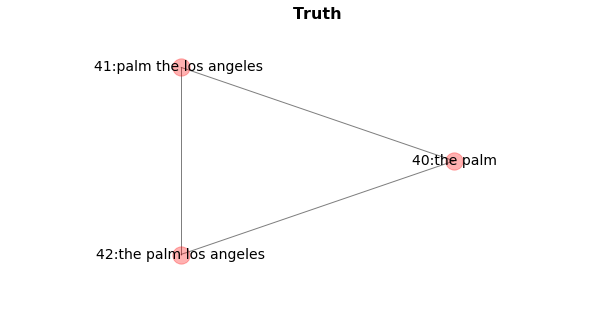

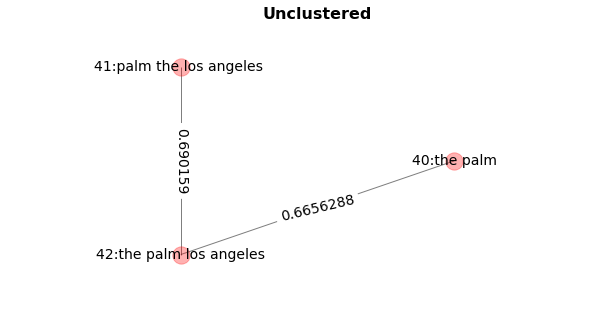

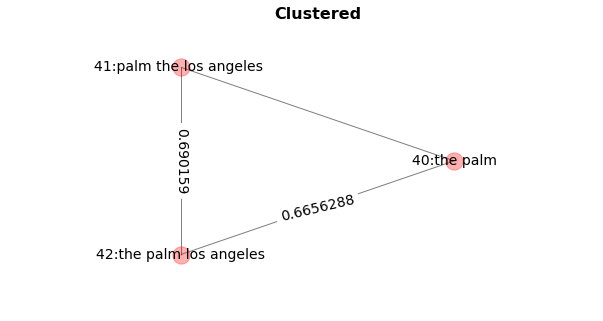

In [49]:
from graph_utils import show_cluster_graphs

diff_ids = {40, 41, 42}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    dedupe_unclustered_pairs_score_dict,
    diff_ids)

## Next Steps

Make sure to learn about other pre-processing methods, indexing techniques, similarity functions, classifiers, etc. Check the talk **The Art and Science of Data Matching** [1] and read the book **Data Matching** [2].

Once we have the clusters, how to consolidate data from many records into one? Check for material on **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

What if new records arrive? Should we merge, unmerge, move records from clusters? Check for material on **Incremental Record Linkage**:
  - Dedupe approach is to either add to an existing cluster or create a new cluster. You can use a [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects) with previously deduped data, then merge new matches into it, and index new nonmatches.
  - Other approaches, check papers:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

Also worth checking the **Privacy** implications of Record Linkage:
- Christen, chapter 8 [2]
- [k-anonymity](https://desfontain.es/privacy/k-anonymity.html), [k-map](https://desfontain.es/privacy/k-map.html), [δ-presence](https://desfontain.es/privacy/delta-presence.html)
- [Why differential privacy is awesome](https://desfontain.es/privacy/differential-privacy-awesomeness.html)

## References

- **Referenced** by this talk:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Other **talks** about Record Linkage with Python:
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Thank you!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br?dedupe-slides=1)

Special thanks to Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742), Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg), and Jonathan de Bruin [@J535D165](https://github.com/J535D165).